<a href="https://colab.research.google.com/github/vanshuwjoshi/2048-Game/blob/main/Tutorials-Andrej-Karpathy/NNs_and_Backpropagation_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

In [3]:
def trace(root):
    ## build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  ## LR = Left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        ## for any value in graph create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._operation:
            dot.node(name=uid + n._operation, label=n._operation)
            dot.edge(uid + n._operation, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)
    return dot

In [4]:
class Value:
    def __init__(self, data, _children=(), _operation="", label=""):
      self.data = data
      self.grad = 0.0
      self._backward = lambda: None
      self._prev = set(_children)
      self._operation = _operation
      self.label = label

    def __repr__(self):
      return f"Value(data={self.data})"

    def __add__(self, other_data):
      ## if other_data is an int we cannot perform add
      ## therefore, we wrap that int to Value class
      if not isinstance(other_data, Value):
        other_data = Value(other_data)
      output = Value(self.data + other_data.data, (self, other_data), "+")
      def _backward():
        self.grad += 1.0 * output.grad
        other_data.grad += 1.0 * output.grad
      output._backward = _backward
      return output

    def __mul__(self, other_data):
      ## if other_data is an int we cannot perform mul
      ## therefore, we wrap that int to Value class
      if not isinstance(other_data, Value):
        other_data = Value(other_data)
      output = Value(self.data * other_data.data, (self, other_data), "*")
      def _backward():
        self.grad += output.grad * other_data.data
        other_data.grad += output.grad * self.data
      output._backward = _backward
      return output

    ## Power function to handle int and float powers
    def __pow__(self, other_data):
      assert isinstance(other_data, (int, float)), "only supporting int/float powers for now"
      output = Value(self.data**other_data, (self, ), label=f"**{other_data}")

      def _backward():
        self.grad += (other_data * (self.data**(other_data-1)))*output.grad
      output._backward = _backward
      return output

    ## the above function can perform Value * 2 but not 2 * Value
    ## to handle this, Python has __rmul__
    def __rmul__(self, other_data):
      ## this is a fallback function, if __mul__ does not work
      ## python redirects to this function to perform
      ## other_data * self
      return self * other_data

    def __truediv__(self, other_data):
      ## division of self/other_data = self*(other_data)^(-1)
      return self * other_data**-1 ## will use __pow__(other_data, -1)

    def __sub__(self, other_data):
      return self + (other_data*-1)

    def tanh(self):
      n = self.data
      tanh_n = (math.exp(2*n)-1)/(math.exp(2*n)+1)
      output = Value(tanh_n, (self, ), "tanh")
      def _backward():
        self.grad += (1 - tanh_n**2)*output.grad
      output._backward = _backward
      return output

    ## Exponential function
    def exp(self):
      n = self.data
      output = Value(math.exp(n), (self, ), "exp")
      def _backward():
        ## gradient is just math.exp(n), stored in output.data
        self.grad += (output.data)*output.grad
      output._backward = _backward
      return output

    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1
      for node in reversed(topo):
        node._backward()


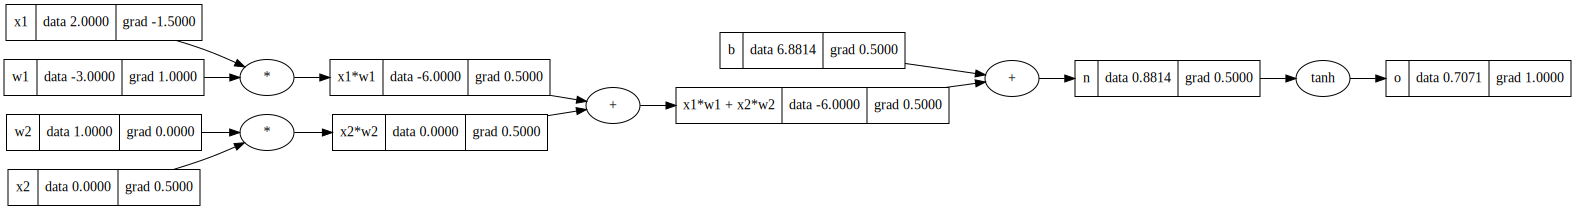

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

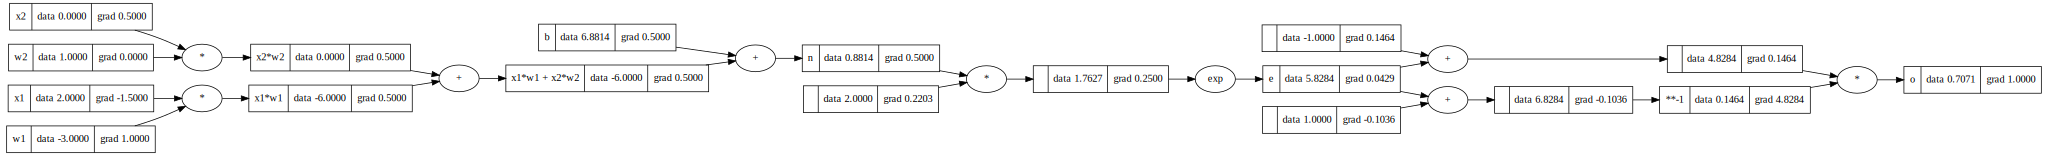

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

## breaking up tanh
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

## Using Pytorch

In [7]:
import torch

## creating tensor - n-dimensional arrays
torch.Tensor([[2,3,4],[5,6,7]])

tensor([[2., 3., 4.],
        [5., 6., 7.]])

In [8]:
x = torch.Tensor([2.0])
print(x)
print(x.dtype)
## We want double precision for our calculation
x = x.double()
print(x)
print(x.dtype)

tensor([2.])
torch.float32
tensor([2.], dtype=torch.float64)
torch.float64


In [9]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
## since the above are leaf node, by default pytorch does not save their gradient
## therefore, we need to explicitly mention it to True
n = ((x1*w1)+(x2*w2)) + b
o = torch.tanh(n)
print(o)
print(o.data.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358


`.item()` pops out the value

In [10]:
o.backward()
print(f"gradient of x1: {x1.grad.item()}")
print(f"gradient of w1: {w1.grad.item()}")
print(f"gradient of x2: {x2.grad.item()}")
print(f"gradient of w2: {w2.grad.item()}")

gradient of x1: -1.5000003851533106
gradient of w1: 1.0000002567688737
gradient of x2: 0.5000001283844369
gradient of w2: 0.0


## Creating Multilayered Perceptron (MLP)

In [11]:
class Value:
    def __init__(self, data, _children=(), _operation="", label=""):
      self.data = data
      self.grad = 0.0
      self._backward = lambda: None
      self._prev = set(_children)
      self._operation = _operation
      self.label = label

    def __repr__(self):
      return f"Value(data={self.data})"

    def __add__(self, other_data):
      if not isinstance(other_data, Value):
        other_data = Value(other_data)
      output = Value(self.data + other_data.data, (self, other_data), "+")
      def _backward():
        self.grad += 1.0 * output.grad
        other_data.grad += 1.0 * output.grad
      output._backward = _backward
      return output

    def __mul__(self, other_data):
      if not isinstance(other_data, Value):
        other_data = Value(other_data)
      output = Value(self.data * other_data.data, (self, other_data), "*")
      def _backward():
        self.grad += output.grad * other_data.data
        other_data.grad += output.grad * self.data
      output._backward = _backward
      return output

    def __pow__(self, other_data):
      assert isinstance(other_data, (int, float)), "only supporting int/float powers for now"
      output = Value(self.data**other_data, (self, ), label=f"**{other_data}")

      def _backward():
        self.grad += (other_data * (self.data**(other_data-1)))*output.grad
      output._backward = _backward
      return output

    def __rmul__(self, other_data):
      return self * other_data

    def __truediv__(self, other_data):
      return self * other_data**-1

    def __sub__(self, other_data):
      return self + (other_data*-1)

    def tanh(self):
      n = self.data
      tanh_n = (math.exp(2*n)-1)/(math.exp(2*n)+1)
      output = Value(tanh_n, (self, ), "tanh")
      def _backward():
        self.grad += (1 - tanh_n**2)*output.grad
      output._backward = _backward
      return output

    def exp(self):
      n = self.data
      output = Value(math.exp(n), (self, ), "exp")
      def _backward():
        self.grad += (output.data)*output.grad
      output._backward = _backward
      return output

    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1
      for node in reversed(topo):
        node._backward()


In [12]:
## Single Neuron
class Neuron:
  def __init__(self, num_inputs):
    ## get list of random weights
    self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]
    ## get bias term
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    ## act = w*x + b
    ## since w and x are arrays we zip() them to create tuples of values
    ## at same position
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    output = act.tanh()
    return output

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.021707639647157745)

In [13]:
## One-layer of neuron
class Layer:
  def __init__(self, num_inputs, num_outputs):
    ## takes in num_inputs and num_outputs
    ## initialize num_outputs neurons that take num_inputs values
    self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

  def __call__(self, x):
    ## when the function is called:
    ## it generates outputs based on the input x
    output = [n(x) for n in self.neurons]
    ## return the value if num_outputs = 1 else return the list of outputs
    return output[0] if len(output)==1 else output

x = [2.0, 3.0] ## input
l = Layer(2, 4) ## takes in two values -> return 4 values
l(x)

[Value(data=0.9981317627616486),
 Value(data=0.02582144519566713),
 Value(data=0.5065483416158102),
 Value(data=-0.11407738408644987)]

In [14]:
## MLP
class MLP:
  def __init__(self, num_inputs, num_outs):
    ## takes in initial num_inputs and list of number of neurons wanted for each layer
    ## get the all the layers
    all_layers = [num_inputs] + num_outs
    ## for each layer initialize a Layer num_inputs as num of neurons of current
    ## layer and num_outputs as num of neuron of next layer
    self.layers = [Layer(all_layers[i], all_layers[i+1]) for i in range(len(all_layers)-1)]

  def __call__(self, x):
    ## call the layer class for each layer to generate outputs
    for layer in self.layers:
      x = layer(x)
    return x

x = [2.0, 3.0, -1.0]
## take in 3 values -> layer of 2 neurons -> layer of 2 neurons -> final layer of 1 neuron
m = MLP(3, [2, 2, 1])
m(x)

Value(data=-0.62958218879479)

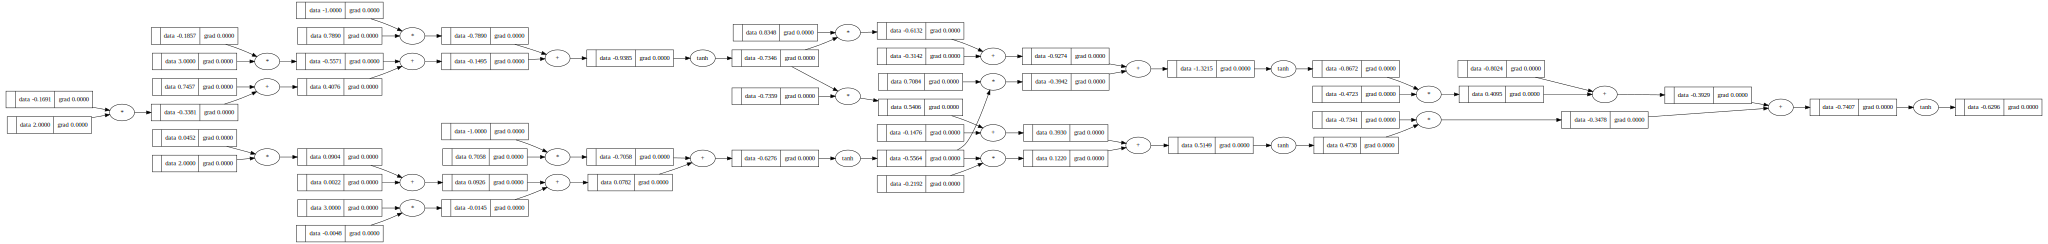

In [15]:
draw_dot(m(x))